In [1]:
%matplotlib inline

In [2]:
import numpy as np
from collections import deque
import pandas as pd
from matplotlib import pyplot as plt

In [3]:
class SARMA_ONS:
    def __init__(self, history, order, order_s, period):
        self.order = order # AR order p
        self.order_s = order_s # Seasonal AR order P
        self.period = period # Seasonal period s
        
        # [X_{t-1}, X_{t-2}, ..., X_{t-(p+s*P)}]
        self.hist_window_reversed = np.zeros(order + period * order_s)
        trunc = list(reversed(history))[:order + period * order_s]
        self.hist_window_reversed[:len(trunc)] = trunc
        self.hist_window_reversed = deque(self.hist_window_reversed, maxlen=order + period * order_s)
        
        self.c = 1
        self.X_max = 2
        self.D = 2 * self.c * np.sqrt(order + order_s)
        self.G = self.D * (self.X_max**2)
        self.lambda_ = 1.0 / (order + order_s)
        self.eta = 0.5 * min(4 * self.G * self.D, self.lambda_) # learning rate
        self.epsilon = 1.0 / (self.eta * self.D)**2
        self.A = np.matrix(np.diag([1] * (order + order_s)) * self.epsilon) # hessian matrix
        self.gamma = np.matrix(np.random.uniform(-self.c, self.c, (order, 1))) # parameters g_1, g_2, ..., g_p
        self.gamma_s = np.matrix(np.random.uniform(-self.c, self.c, (order_s, 1))) # seasonal parameters gs_1, gs_2, ..., gs_P
        
        
    def _compute_backshift(self, polycoef):
        '''
        Compute a_1 * X_{t-1} + a_2 * X_{t-2} + ... + a_k * X_{t-k}
        
        inputs:
         polycoef = [a_0, a_1, a_2, ..., a_k]
         self.hist_window_reversed = [X_{t-1}, X_{t-2}, ..., X_{t-(p+s*P)}]
        '''
        return np.dot(polycoef, [0] + list(self.hist_window_reversed)[:len(polycoef)-1])
        
        
    def predict(self, gamma_polycoef, gamma_s_polycoef):
        '''
        X_pred_t = gamma_polynomial(B) X_t + gamma_s_polynomial(B^s) X_t - gamma_polynomial(B) * gamma_s_polynomial(B^s) X_t
        where
         gamma_polynomial(B) = gamma_1 * B + gamma_2 * B^2 + ... + gamma_p * B^p
         gamma_s_polynomial(B^s) = gamma_s_1 * B^s + gamma_s_2 * B^(2s) + ... + gamma_s_P * B^(Ps)
         
        params:
         gamma_polycoef = [gamma_1, gamma_2, ..., gamma_p]
         gamma_s_polycoef = [[0]*(s-1), gamma_s_1, [0]*(s-1), gamma_s_2, ... , [0]*(s-1), gamma_s_P]
        '''
        gamma_polycoef = [0] + gamma_polycoef
        gamma_s_polycoef = [0] + gamma_s_polycoef
        
        X_pred1 = self._compute_backshift(gamma_polycoef)
        X_pred2 = self._compute_backshift(gamma_s_polycoef)
        
        poly_multiply = np.polymul(np.flip(gamma_polycoef), np.flip(gamma_s_polycoef))
        poly_multiply = np.flip(poly_multiply)
        X_pred3 = self._compute_backshift(poly_multiply)
        return X_pred1 + X_pred2 - X_pred3
    
    
    def update_parameters(self, x, x_pred, gamma_polycoef, gamma_s_polycoef):
        '''
        delta(loss_t)/delta(gamma_i) = -2 * (X_t - X_pred_t) * [B^i * gamma_s_polynomial(B)](X_t), i=1,...,p
        delta(loss_t)/delta(gamma_s_j) = -2 * (X_t - X_pred_t) * [B^(js) * gamma_polynomial(B)](X_t), j=1,...,P
        where
         gamma_polynomial(B) = 1 - gamma_1 * B - gamma_2 * B^2 - ... - gamma_p * B^p
         gamma_s_polynomial(B) = 1 - gamma_s_1 * B^s - gamma_s_2 * B^(2s) - ... - gamma_s_P * B^(Ps)
        
        params:
         gamma_polycoef = [gamma_1, gamma_2, ..., gamma_p]
         gamma_s_polycoef = [[0]*(s-1), gamma_s_1, [0]*(s-1), gamma_s_2, ... , [0]*(s-1), gamma_s_P]
        '''
        gamma_polycoef = [1] + list(-np.array(gamma_polycoef))
        gamma_s_polycoef = [1] + list(-np.array(gamma_s_polycoef))
        
        # compute gradient w.r.t gamma and gamma_s
        polynomial_list = [[0]*i + gamma_s_polycoef for i in range(1, self.order+1)]
        nabla = [self._compute_backshift(polynomial) for polynomial in polynomial_list]
        
        polynomial_s_list = [[0]*(i*self.period) + gamma_polycoef for i in range(1, self.order_s+1)]
        nabla_s = [self._compute_backshift(polynomial_s) for polynomial_s in polynomial_s_list]
        
        nabla_all = -2 * (x - x_pred) * np.array(nabla + nabla_s)
        
        # reshape
        nabla_all = nabla_all.reshape(-1,1)
        
        # update parameters
        self.A += np.dot(nabla_all, nabla_all.T)
        grad = 1 / self.eta * np.dot(np.linalg.inv(self.A), nabla_all)
        self.gamma -= grad[:self.order]
        self.gamma_s -= grad[self.order:]
    
    
    def update_history(self, x):
        self.hist_window_reversed.appendleft(x)
        
    
    def fit_one_step(self, x):
        gamma_polycoef = list(np.array(self.gamma).squeeze(-1)) # [g_1, ..., g_p]
        gamma_s_polycoef = list(np.array(self.gamma_s).squeeze(-1)) # [gs_1, ..., gs_P]
        gamma_s_polycoef = list(np.kron(gamma_s_polycoef, [0]*(self.period-1) + [1])) # [[0]*(s-1), gs_1, [0]*(s-1), gs_2, ..., gs_P]
        
        # predict
        x_pred = self.predict(gamma_polycoef, gamma_s_polycoef)
        
        # compute loss
        loss = (x - x_pred)**2
        
        # update parameters
        self.update_parameters(x, x_pred, gamma_polycoef, gamma_s_polycoef)
        
        # update history
        self.update_history(x)
        
        return x_pred, loss

In [4]:
df = pd.read_csv('data/AirPassengers.csv')
series = df['#Passengers']
X = np.log(series)
split_point = round(len(series) * 0.75)

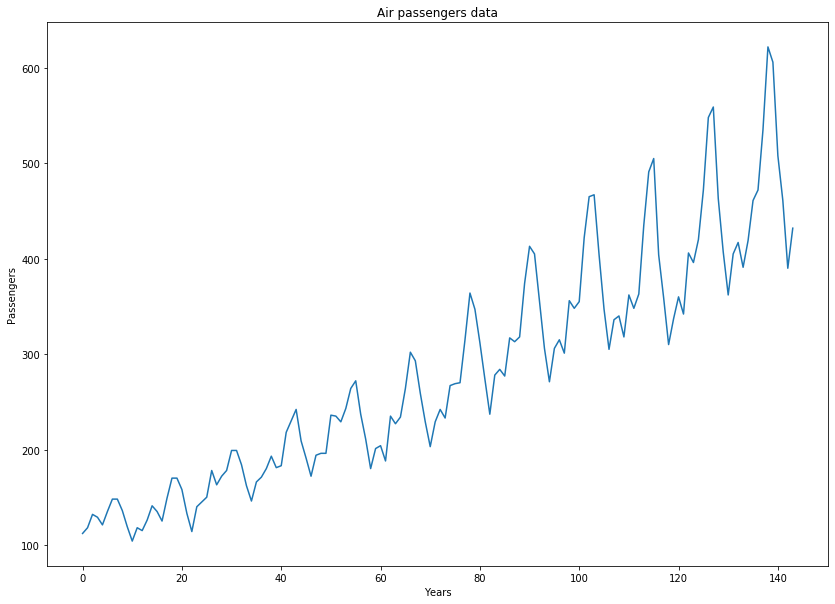

In [5]:
plt.figure(figsize=(14, 10))
plt.plot(series)
plt.title('Air passengers data')
plt.xlabel('Years')
plt.ylabel('Passengers')
plt.show()

In [6]:
model = SARMA_ONS([], order=1, order_s=4, period=12)

X_pred = []
squared_losses = []
mean_squared_losses = []
for x in X:
    x_pred, loss = model.fit_one_step(x)
    X_pred.append(x_pred)
    squared_losses.append(loss)
    mean_squared_losses.append(np.mean(squared_losses))

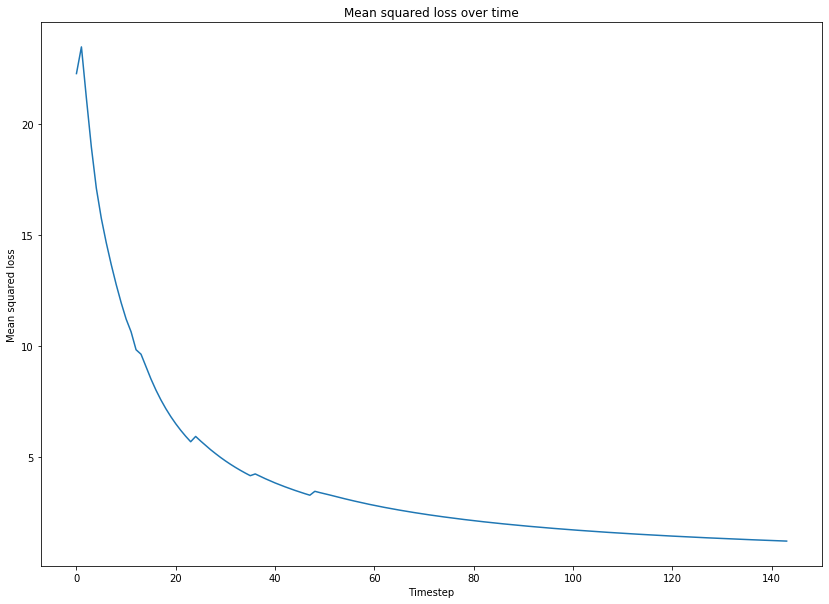

In [7]:
plt.figure(figsize=(14, 10))
plt.plot(mean_squared_losses)
plt.title('Mean squared loss over time')
plt.xlabel('Timestep')
plt.ylabel('Mean squared loss')
plt.show()

In [8]:
forecast = np.exp(pd.Series(X_pred, index=series.index))[split_point:]
testing = series[split_point:]
print('MAPE: ', np.mean(np.abs((testing - forecast) / testing)))
print('RMSE: ', np.sqrt(np.mean((testing - forecast)**2)))

MAPE:  0.04691548013447126
RMSE:  24.74419374498644


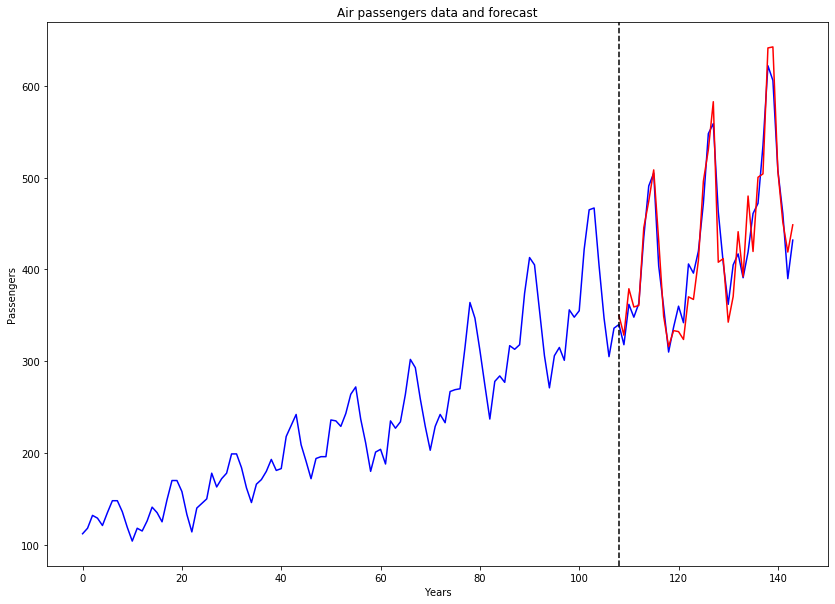

In [9]:
plt.figure(figsize=(14, 10))
plt.plot(series, 'b')
plt.plot(forecast, 'r')
plt.title('Air passengers data and forecast')
plt.xlabel('Years')
plt.ylabel('Passengers')
plt.axvline(x=series.index[split_point], linestyle='--', color='black')
plt.show()